In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install albumentations
!pip install -q tensorflow opencv-python

In [11]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import tensorflow as tf


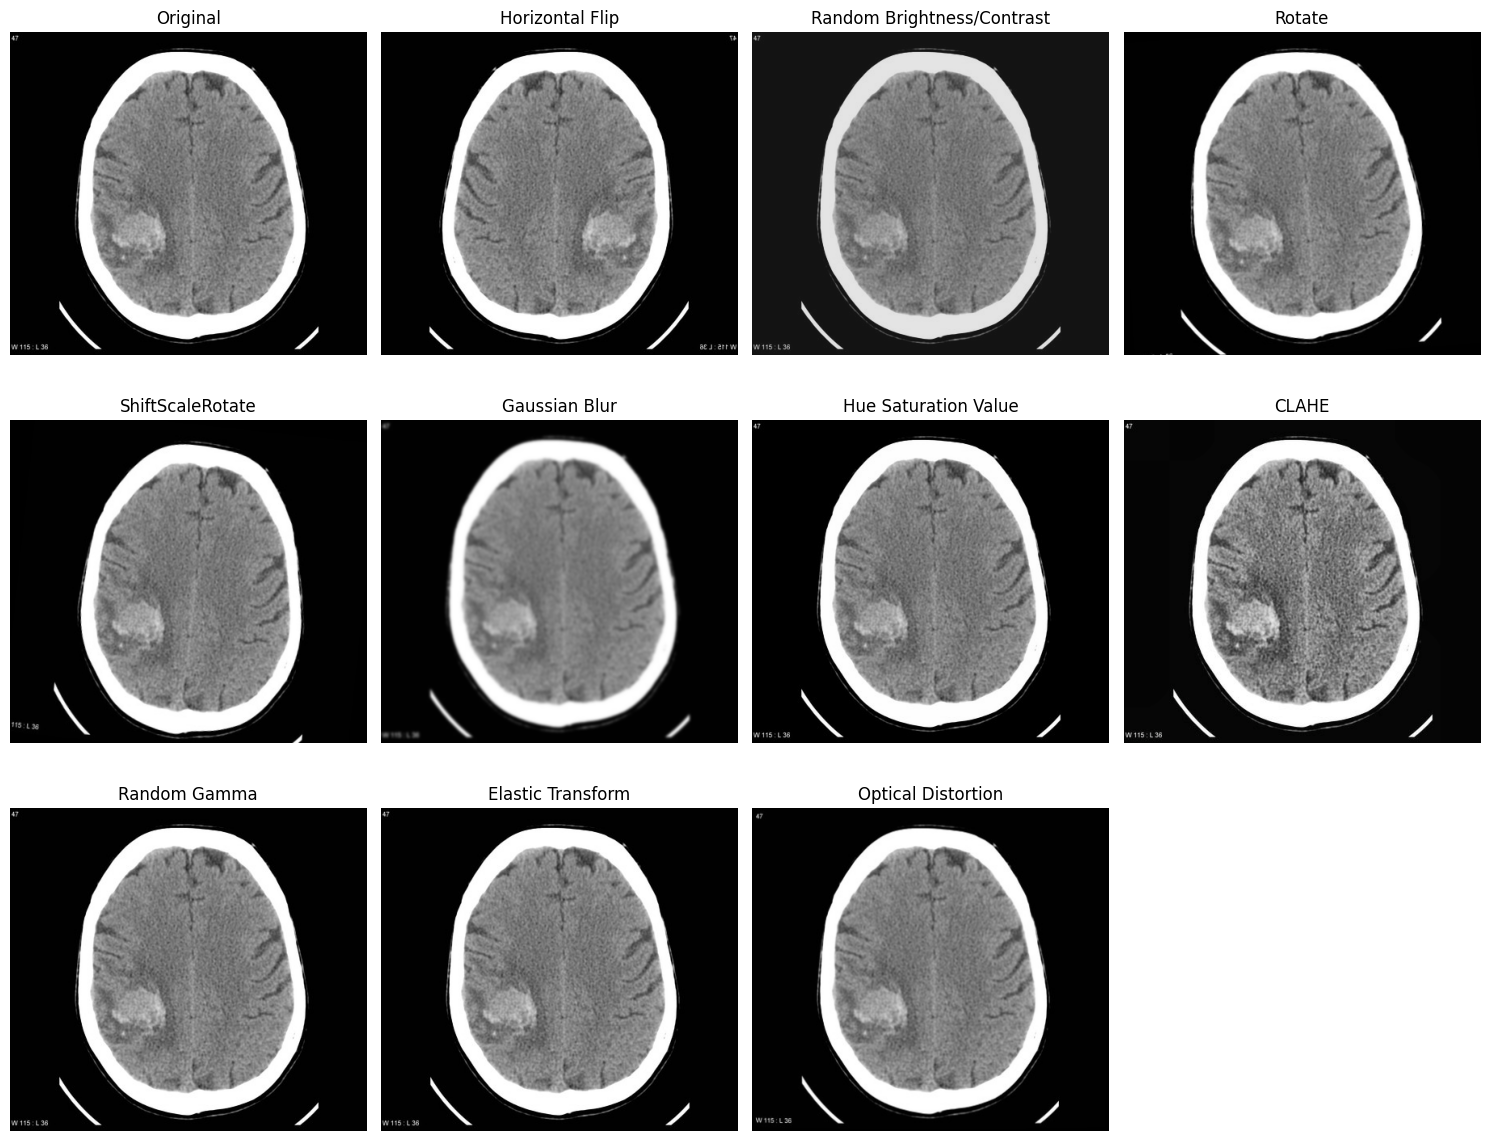

In [61]:
# List of transformations
transformations = [
    ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
    ("Random Brightness/Contrast", A.RandomBrightnessContrast(p=1.0)),
    ("Rotate", A.Rotate(limit=20, p=1.0)),
    ("ShiftScaleRotate", A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1.0)),
    ("Gaussian Blur", A.GaussianBlur(p=1.0)),
    ("Hue Saturation Value", A.HueSaturationValue(p=1.0)),
    ("CLAHE", A.CLAHE(p=1.0)),
    ("Random Gamma", A.RandomGamma(p=1.0)),
    ("Elastic Transform", A.ElasticTransform(p=1.0)),
    ("Optical Distortion", A.OpticalDistortion(p=1.0))
]

# Plotting
plt.figure(figsize=(15, 12))
plt.subplot(3, 4, 1)
plt.imshow(original)
plt.title("Original")
plt.axis('off')

# Apply and display each transformation
for i, (name, transform) in enumerate(transformations):
    augmented = transform(image=original)["image"]
    plt.subplot(3, 4, i + 2)
    plt.imshow(augmented)
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.GaussianBlur(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.CLAHE(p=0.3),
    A.RandomGamma(p=0.3),
    A.ElasticTransform(p=0.2),
    A.OpticalDistortion(p=0.2)
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
IMG_SIZE = 128  # or any preferred size
data = []
labels = []

def load_and_augment_images(folder_path, label):
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Add original image
        data.append(image)
        labels.append(label)

        # Add 10 augmentations
        for _ in range(10):
            augmented = transform(image=image)
            aug_img = augmented['image']
            data.append(aug_img)
            labels.append(label)

load_and_augment_images('/content/drive/MyDrive/brain-tumor/no', 0)
load_and_augment_images('/content/drive/MyDrive/brain-tumor/yes', 1)

data = np.array(data)
labels = np.array(labels)


100%|██████████| 155/155 [00:08<00:00, 18.47it/s]


In [12]:
data = data / 255.0  # Normalize
labels = to_categorical(labels, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), name='conv1'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7048 - loss: 0.7088 - val_accuracy: 0.8223 - val_loss: 0.3842
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 70s 983ms/step - accuracy: 0.8286 - loss: 0.3869 - val_accuracy: 0.8671 - val_loss: 0.3161
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 78s 945ms/step - accuracy: 0.8916 - loss: 0.2714 - val_accuracy: 0.8851 - val_loss: 0.2881
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 963ms/step - accuracy: 0.9156 - loss: 0.2163 - val_accuracy: 0.8869 - val_loss: 0.2701
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 946ms/step - accuracy: 0.9331 - loss: 0.1738 - val_accuracy: 0.9031 - val_loss: 0.2714
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 962ms/step - accuracy: 0.9647 - loss: 0.1107 - val_accuracy: 0.8815 - val_loss: 0.4144
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 937ms/step - accuracy: 0.9609 - loss: 0.1103 - val_accuracy: 0.8905 - val_loss: 0.3747
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 960ms/step - accuracy: 0.9610 - loss: 0.0976 - val_accurac

In [15]:
model.save('//content/drive/MyDrive/brain-tumor/brain_tumor_classifier.h5')


Saving 3.jpeg to 3.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


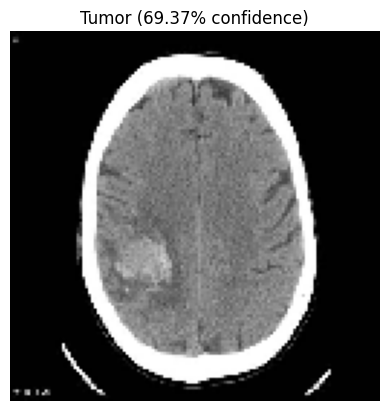

In [37]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0]
predicted_class = np.argmax(prediction)
confidence = prediction[predicted_class]

labels = ['No Tumor', 'Tumor']
label = labels[predicted_class]

plt.imshow(img)
plt.axis('off')
plt.title(f'{label} ({confidence*100:.2f}% confidence)')
plt.show()


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [39]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step


In [70]:
class_names = ['No Tumor', 'Tumor']

print("Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

acc = accuracy_score(y_test_labels, y_pred_labels)
prec = precision_score(y_test_labels, y_pred_labels)
rec = recall_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels)

print(f"Accuracy :  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.95      0.80      0.87       215
       Tumor       0.89      0.97      0.93       342

    accuracy                           0.90       557
   macro avg       0.92      0.89      0.90       557
weighted avg       0.91      0.90      0.90       557

Accuracy :  0.9048
Precision: 0.8853
Recall:    0.9708
F1 Score:  0.9261


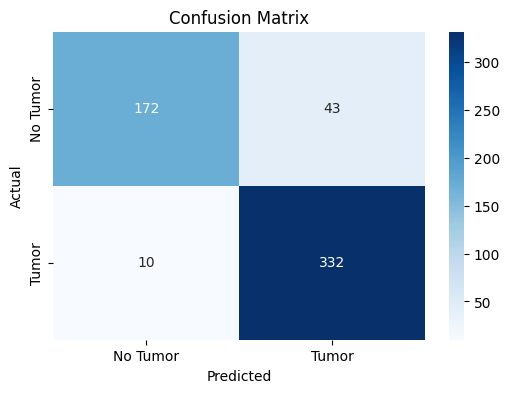

In [41]:
cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


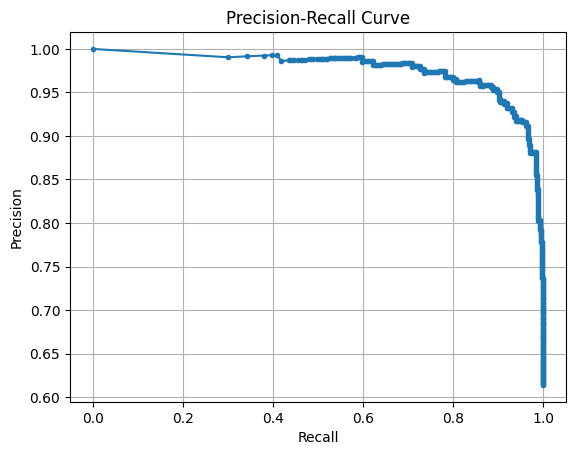

In [42]:
from sklearn.metrics import precision_recall_curve

# Get positive class scores (tumor class = 1)
y_scores = y_pred_probs[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_labels, y_scores)

plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


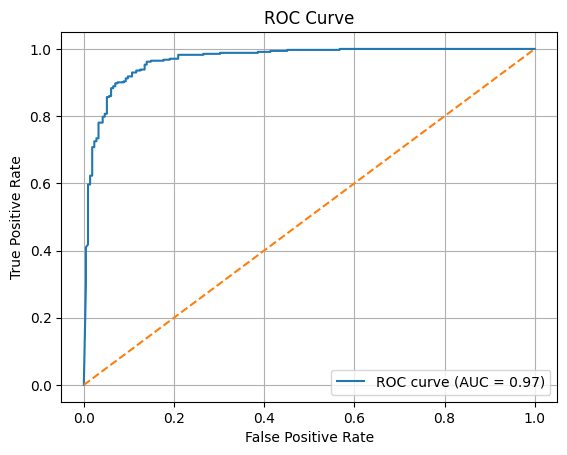

In [43]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_labels, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
